## Imports & Global Variables

In [57]:
import torch
import pandas as pd
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [58]:
csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
# csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

batch_size = 32
hidden_size = 64
lr=0.001
num_epochs = 200
lambda_val = 0.002

## Importing Data

##### Custom Dataset

In [59]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, df, scaler, transform=None):
        super().__init__()
        self.features = df.iloc[:, 1:]
        self.labels = df.iloc[:, 0]
        
        self.features = scaler.transform(self.features)

        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

##### Importing the data and scaling 

In [60]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_dataset = SimpleDataset(df=train_df, scaler=scaler)
valid_dataset = SimpleDataset(df=valid_df, scaler=scaler)
test_dataset = SimpleDataset(df=test_df, scaler=scaler)

##### Converting into DataLoaders

In [61]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Modeling

##### Feed Forward Neural Network

In [62]:
class SimpleNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.f1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.f2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.f2(x)
        return x

##### Initializing model / cost function / optimizer

In [63]:
input_size = train_dataset.features.shape[1] 
output_size = len(set(train_dataset.labels))

model_no_reg = SimpleNN(input_size, hidden_size, output_size)
model_with_reg = SimpleNN(input_size, hidden_size, output_size)

criterion = torch.nn.CrossEntropyLoss()

optimizer_no_reg = torch.optim.Adam(model_no_reg.parameters(), lr=lr)
optimizer_with_reg = torch.optim.Adam(model_with_reg.parameters(), lr=lr)

##### Training the model

In [64]:
def train(model, train_loader, valid_loader, num_epochs, criterion, optimizer, l2_regularization=False):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    train_loader: training set as a DataLoader()
    valid_loader: validation set as a DataLoader()
    num_epochs: Number of epochs
    criterion: Loss function
    optimizer: Optimization function
    l2_regularization: Boolean value representing if you want to use L2-regularization
    """
    
    train_losses = []
    valid_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0

        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)

            if l2_regularization:
                reg = lambda_val * torch.sum(model.f1.weight ** 2)
                loss = loss + reg

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        running_valid_loss = 0.0

        with torch.no_grad():
            for features, labels in valid_loader:
                outputs = model(features)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        valid_losses.append(epoch_valid_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Valid Loss: {epoch_valid_loss:.4f}")
        
    return train_losses, valid_losses

In [65]:
train_losses_no_reg, valid_losses_no_reg = train(model_no_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_no_reg, l2_regularization=False)
train_losses_with_reg, valid_losses_with_reg = train(model_with_reg, train_loader, valid_loader, num_epochs, criterion, optimizer_with_reg, l2_regularization=True)

/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_64476/246721670.py:16: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 10/200, Train Loss: 0.4800, Valid Loss: 0.5096
Epoch 20/200, Train Loss: 0.4530, Valid Loss: 0.4701
Epoch 30/200, Train Loss: 0.4241, Valid Loss: 0.4507
Epoch 40/200, Train Loss: 0.4326, Valid Loss: 0.4309
Epoch 50/200, Train Loss: 0.4107, Valid Loss: 0.4091
Epoch 60/200, Train Loss: 0.3788, Valid Loss: 0.3887
Epoch 70/200, Train Loss: 0.3874, Valid Loss: 0.3688
Epoch 80/200, Train Loss: 0.3262, Valid Loss: 0.3467
Epoch 90/200, Train Loss: 0.2981, Valid Loss: 0.3226
Epoch 100/200, Train Loss: 0.3143, Valid Loss: 0.3004
Epoch 110/200, Train Loss: 0.2892, Valid Loss: 0.2797
Epoch 120/200, Train Loss: 0.2643, Valid Loss: 0.2563
Epoch 130/200, Train Loss: 0.2507, Valid Loss: 0.2353
Epoch 140/200, Train Loss: 0.2224, Valid Loss: 0.2161
Epoch 150/200, Train Loss: 0.2085, Valid Loss: 0.1981
Epoch 160/200, Train Loss: 0.1895, Valid Loss: 0.1835
Epoch 170/200, Train Loss: 0.1839, Valid Loss: 0.1695
Epoch 180/200, Train Loss: 0.1950, Valid Loss: 0.1570
Epoch 190/200, Train Loss: 0.1722, Va

##### Testing the model (with accuracy)

In [66]:
def test(model, test_loader):
    """
    Parameters
    ----------
    model: Pytorch nn.Module model
    test_loader: test set as a DataLoader()
    """
    
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features)            

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return test_accuracy

In [67]:
test_accuracy = test(model_no_reg, test_loader)

Test Accuracy: 100.0000


/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_64476/246721670.py:16: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


# Plotting Loss Curves and Decision Boundaries

Recall that L2-Regularization is a technique used to limit overfitting the training set by increases bias between the training set and test sets while decreasing the variance. You can see the difference in plots below that the training loss performance is not as good, but the validation loss still has low loss. 

In [68]:
def plot_loss_curves(train_losses, valid_losses, postfix=""):
  plt.plot(list(range(1, (num_epochs) + 1)), train_losses, label='train loss')
  plt.plot(list(range(1, (num_epochs) + 1)), valid_losses, label='valid loss')
  plt.title(f'Loss Curves for the {csv_file_prefix.capitalize()} Dataset ({postfix})')
  plt.xlabel('epoch')
  plt.ylabel('cross entropy loss')
  plt.legend()

  plt.show()

def plot_decision_boundaries(model, title=""):
  x_min, x_max = train_dataset.features[:, 0].min(), train_dataset.features[:, 0].max()
  y_min, y_max = train_dataset.features[:, 1].min(), train_dataset.features[:, 1].max()
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

  grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
  with torch.no_grad():
      Z = model(grid_points) 
      Z = Z.argmax(dim=1).numpy()

  Z = Z.reshape(xx.shape)

  plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

  for inputs, label in train_loader:
      inputs = inputs.numpy()
      label = label.numpy()
      plt.scatter(inputs[:, 0], inputs[:, 1], c=label, edgecolor='k', cmap='coolwarm', marker='o')

  plt.title(title)
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")
  plt.show()

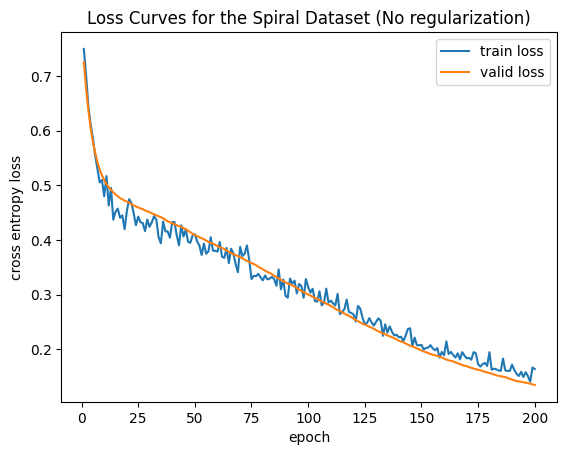

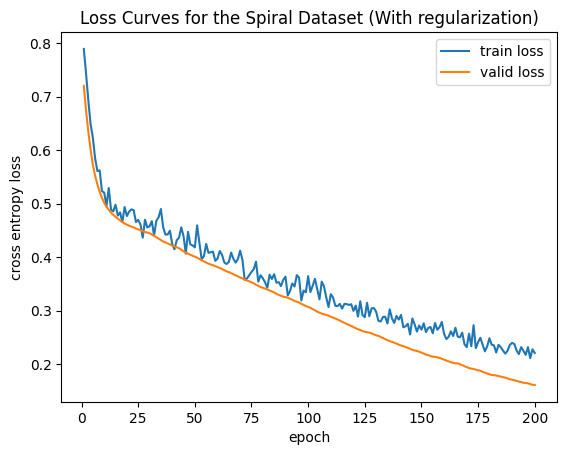

In [69]:
plot_loss_curves(train_losses_no_reg, valid_losses_no_reg, postfix="No regularization")
plot_loss_curves(train_losses_with_reg, valid_losses_with_reg, postfix="With regularization")

/var/folders/0b/t_zq87x958lc5wvb065nb89m0000gn/T/ipykernel_64476/246721670.py:16: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(self.labels[idx], dtype=torch.long)


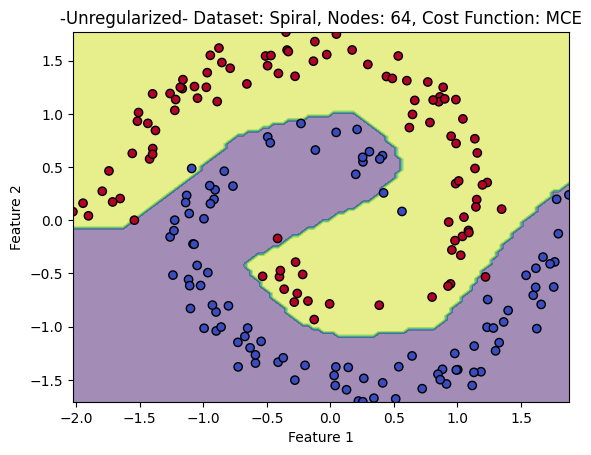

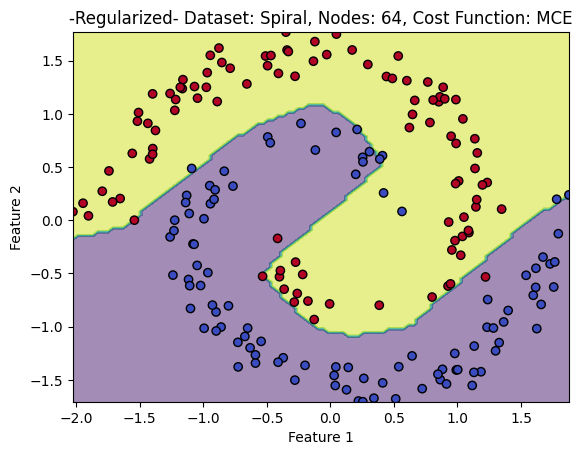

In [70]:
plot_decision_boundaries(model_no_reg, title=f"-Unregularized- Dataset: {csv_file_prefix.capitalize()}, Nodes: {hidden_size}, Cost Function: MCE")
plot_decision_boundaries(model_with_reg, title=f"-Regularized- Dataset: {csv_file_prefix.capitalize()}, Nodes: {hidden_size}, Cost Function: MCE")
